In [10]:
from model import SuperResolutionVAEModel, SuperResolutionVAEConfig
# from gpt_dataset import get_dataloader
import matplotlib.pyplot as plt

import torch

In [116]:
config = SuperResolutionVAEConfig()
config.testing=True
model = SuperResolutionVAEModel(config)
x = torch.randn((64, 3, 32, 32))
target = torch.randn((64, 3, 64, 64))

y, loss = model(x, target)
print(f"{y.shape=}")
print(f"{model=}")
f"{model.num_parameters()=} {loss.item()=}"

y.shape=torch.Size([64, 3, 64, 64])
model=SuperResolutionVAEModel(
  (encoder): ModuleDict(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): ModuleDict(
    (conv2): ConvTranspose2d(4, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv0): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


'model.num_parameters()=87067 loss.item()=1031714.0'

In [117]:
# to be able to visualize the gradients

for _, layer in model.activations.items():
    layer.retain_grad() # AFTER_DEBUG: would take out retain_graph
for p in model.parameters():
    p.grad = None
loss.backward() 

layer 0 (             mu): mean +0.00, std 1.00, saturated: 32.48%
layer 1 (        log_var): mean -0.00, std 1.00, saturated: 32.53%
layer 2 (   latent_space): mean -0.01, std 1.63, saturated: 50.76%


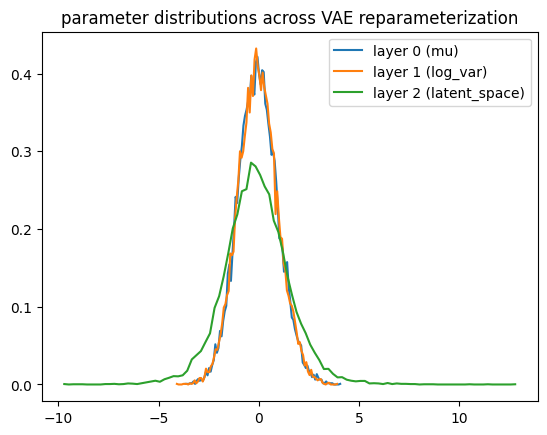

In [120]:

for i, (name, activation) in enumerate({i: model.activations[i] for i in ["mu", "log_var", "latent_space"]}.items()):
    out = activation.data
    print('layer %d (%15s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, name, out.mean(), out.std(), (out.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(out, density=True)
    plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {i} ({name})")
plt.title(f"parameter distributions across VAE reparameterization")
plt.legend()
plt.show()

layer 0 (             mu): mean -0.09, std 2.48, saturated: 68.55%
layer 1 (        log_var): mean +0.33, std 1.83, saturated: 31.56%
layer 2 (   latent_space): mean -0.09, std 2.24, saturated: 65.03%


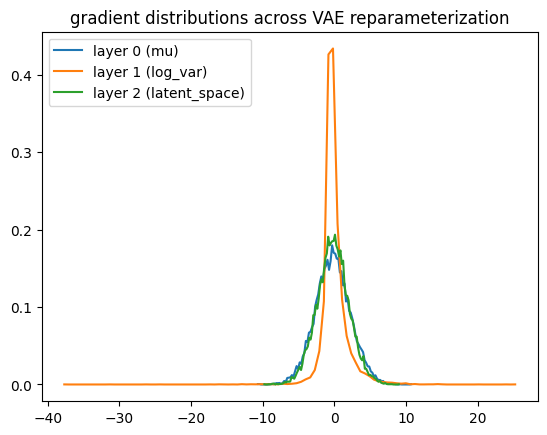

In [121]:
import matplotlib.pyplot as plt

for i, (name, activation) in enumerate({i: model.activations[i] for i in ["mu", "log_var", "latent_space"]}.items()):
    out = activation.grad.data
    print('layer %d (%15s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, name, out.mean(), out.std(), (out.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(out, density=True)
    plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {i} ({name})")
plt.title(f"gradient distributions across VAE reparameterization")
plt.legend()
plt.show()

layer 0 (encoder_relu1  ): mean +0.23, std 0.33, saturated: 4.48%
layer 1 (decoder_relu2  ): mean +0.38, std 0.67, saturated: 15.78%
layer 2 (decoder_relu1  ): mean +0.39, std 0.89, saturated: 19.30%
layer 3 (decoder_sigmoid): mean +0.50, std 0.22, saturated: 0.73%


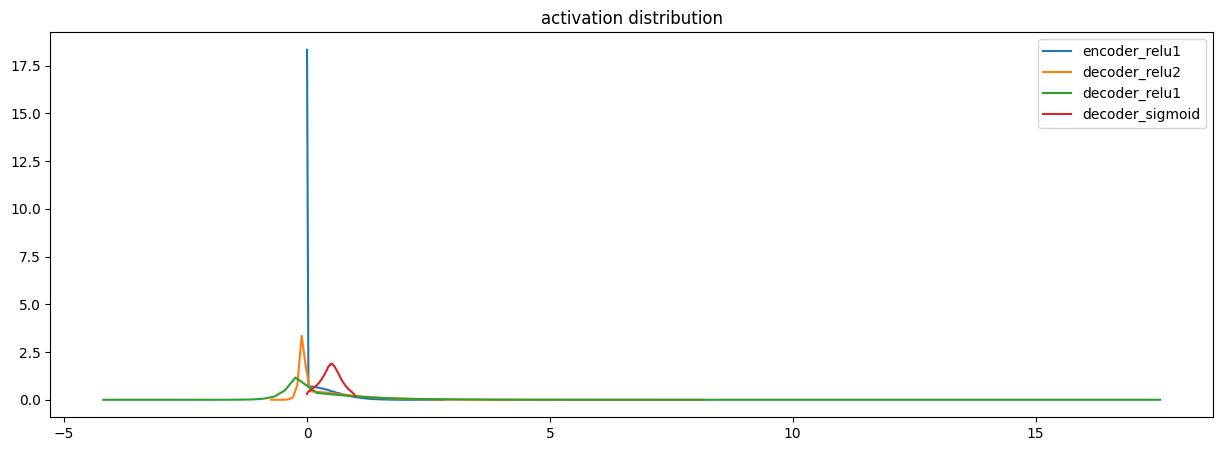

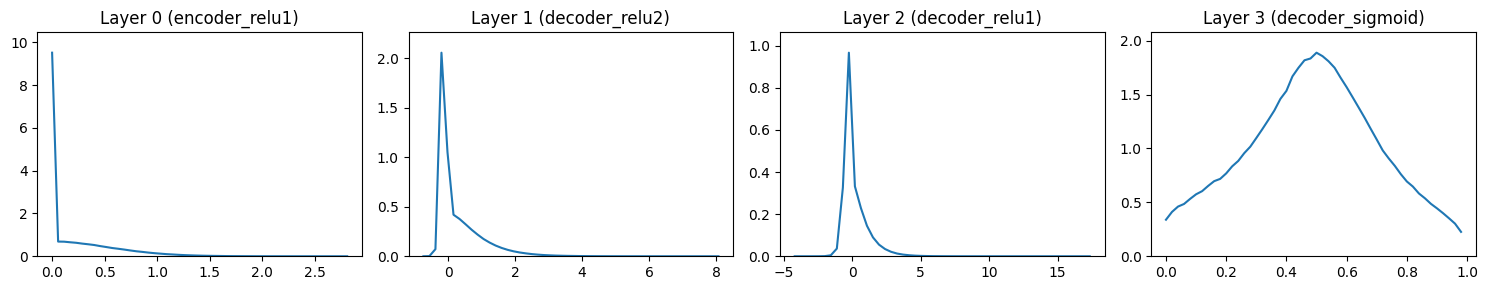

In [152]:
model2 = model
for p in ["mu", "log_var", "latent_space"]:
    if p in model2.activations:
        model2.activations.pop(p)

plt.figure(figsize=(15, 5))
for i, (name, activation) in enumerate(model2.activations.items()):
    out = activation.data
    
    # Print statistics
    print(f'layer {i} ({name:15s}): mean {out.mean():+.2f}, std {out.std():.2f}, saturated: {(out.abs() > 0.97).float().mean()*100:.2f}%')
    hy, hx = torch.histogram(out, density=True)
    plt.plot(hx[:-1].detach(), hy.detach(), label=name)
plt.legend()
plt.title(f"activation distribution")
plt.show()

# Create a figure with 1x3 subplots
fig, axs = plt.subplots(1, len(model2.activations), figsize=(15, 3))

for i, (name, activation) in enumerate(model2.activations.items()):
    out = activation.data
    hy, hx = torch.histogram(out, bins=50, density=True)
    
    # Plot the histogram in the current subplot
    axs[i].plot(hx[:-1].detach(), hy.detach())
    axs[i].set_title(f"Layer {i} ({name})")
    axs[i].set_ylim(0, hy.max() * 1.1)  # Adjust y-axis limit for better visibility

plt.tight_layout()  # Ensure subplots fit well in the figure
plt.show()

layer 0 (encoder_relu1): mean +0.00, std 1.03, saturated: 28.48%
torch.Size([64, 64, 16, 16]) torch.Size([100]) torch.Size([101])
layer 1 (decoder_relu2): mean -0.00, std 0.44, saturated: 2.93%
torch.Size([64, 128, 16, 16]) torch.Size([100]) torch.Size([101])
layer 2 (decoder_relu1): mean +0.00, std 0.27, saturated: 0.09%
torch.Size([64, 64, 32, 32]) torch.Size([100]) torch.Size([101])
layer 3 (decoder_sigmoid): mean +0.99, std 2.05, saturated: 67.43%
torch.Size([64, 3, 64, 64]) torch.Size([100]) torch.Size([101])


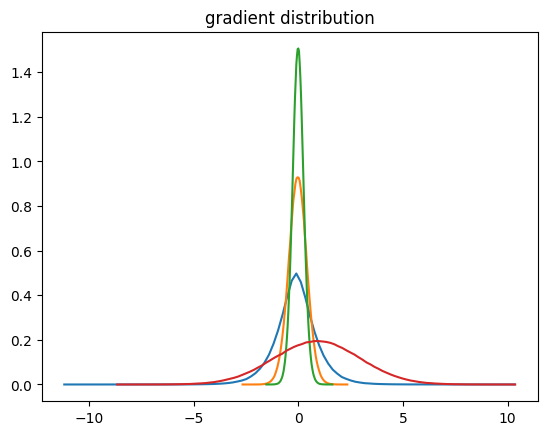

In [123]:

# Plot distributions
model2 = model
for p in ["mu", "log_var", "latent_space"]:
    if p in model2.activations:
        model2.activations.pop(p) 
for i, (name, activation) in enumerate(model2.activations.items()):
    out = activation.grad.data
    #plt.figure()
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, name, out.mean(), out.std(), (out.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(out, density=True)
    print(activation.shape, hy.shape, hx.shape)
    plt.plot(hx[:-1].detach(), hy.detach())
plt.title(f"gradient distribution")
plt.show()

layer   0 (encoder.conv1): mean -0.00, std 0.11, saturated: 0.00%
layer   2 (encoder.conv2): mean +0.00, std 0.02, saturated: 0.00%
layer   6 (decoder.conv2): mean +0.00, std 0.02, saturated: 0.00%
layer  10 (decoder.conv1): mean +0.00, std 0.02, saturated: 0.00%
layer  14 (decoder.conv0): mean -0.00, std 0.11, saturated: 0.00%


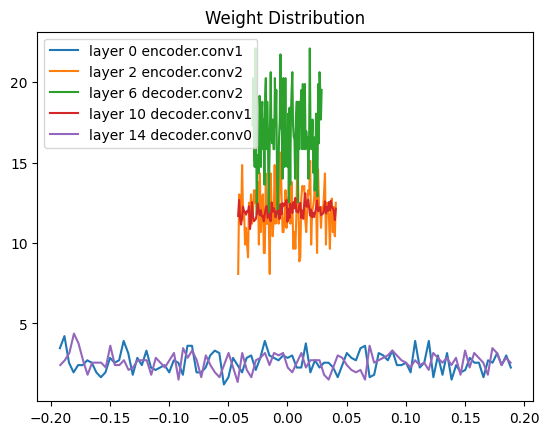

In [124]:
for i, (name, out) in enumerate(model.named_parameters()):
    if out.ndim == 4:
        name = name.replace('.weight','')
        print('layer %3d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, name, out.mean(), out.std(), (out.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f"layer {i} {name}")

plt.legend()
plt.title("Weight Distribution")
plt.show()

## Inference

In [23]:
from gpt_dataset import get_dataloader
from main import LitSuperResolutionVAE
import matplotlib.pyplot as plt
import numpy as np
train_dset, val_dset, test_dset = get_dataloader()


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.5877128].


tensor(20)
torch.Size([3, 64, 64])


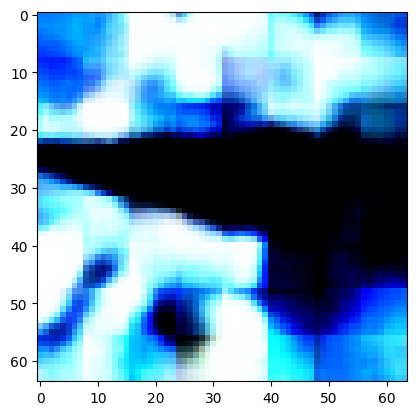

In [27]:
model = LitSuperResolutionVAE.load_from_checkpoint(f"checkpoint.ckpt")
model.eval()

# Perform inference with the loaded model
def upscale_image(model, lr_image):
    model.eval()
    with torch.no_grad():
        lr_image = lr_image.unsqueeze(0)  # Add batch dimension
        recon_image = model(lr_image)
        return recon_image.squeeze(0)  # Remove batch dimension
       
        
        
# Upscale a sample image
# sample_idx = int(input(f"Enter an index between 0 and {len(test_dset) - 1}: "))
idx = torch.randint(len(test_dset), (1,))[0]
print(idx)
lr_image, hr_image = test_dset.dataset[idx.item()]
upscaled_image = upscale_image(model, lr_image)
print(upscaled_image.shape)
generated = upscaled_image.numpy()
plt.imshow(np.transpose(hr_image, (1, 2, 0)))
plt.imshow(np.transpose(lr_image, (1, 2, 0)))
plt.imshow(np.transpose(generated, (1, 2, 0)))